In [271]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import sqlite3
import sys
from typing import Tuple
import os
import operator
import matplotlib.pyplot as plt


# Append the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Now you can import the settings module
import settings

# UTILS

## Dict

In [ ]:
# Abreviatures extracted from https://laligafv.foroactivo.com/t5325-abreviaturas-de-los-equipos
team_names_3 = {
    "Alavés": "ALA",
    "Athletic": "ATH",
    "Atlético Madrid": "ATM",
    "Barcelona": "BAR",
    "CA Osasuna": "OSA",
    "Celta de Vigo": "CEL",
    "Cádiz CF": "CAD",
    "Elche CF": "ELC",
    "Getafe": "GET",
    "Granada CF": "GRA",
    "Levante": "LEV",
    "Real Betis": "BET",
    "Real Madrid": "RMA",
    "Real Sociedad": "RSO",
    "Real Valladolid": "VLL",
    "SD Eibar": "EIB",
    "SD Huesca": "HUE",
    "Sevilla FC": "SEV",
    "Valencia": "VAL",
    "Villarreal": "VIL",
}

## Functions

In [ ]:
def select_team(df: DataFrame, team: str) -> DataFrame:
    """
    Creates a dataframe with all matches for a specific team, adding interesting values as if the team is local or visitor,
    and if the team won, tied, or lost.

    :param df: DataFrame containing match data.
    :type df: pd.DataFrame
    :param team: The name of the team to select matches for.
    :type team: str
    :return: DataFrame with matches for the specified team, including additional columns
             indicating if the team is local, if the team won, tied, or did not lose.
    :rtype: pd.DataFrame
    """
    df_team = df.loc[(df["home_team"] == team) | (df["away_team"] == team)].copy()
    df_team["is_local"] = df_team["home_team"] == team
    df_team["is_winner"] = ((df_team["winner"] == 1) & df_team["is_local"]) | (
        (df_team["winner"] == 2) & ~df_team["is_local"]
    )
    df_team["is_tie"] = df_team["winner"] == 0
    df_team["is_non_lose"] = df_team["is_winner"] | df_team["is_tie"]
    return df_team

In [ ]:
def filter_season(df: DataFrame, season: str) -> DataFrame:
    """
    Filters and returns the matches within a specified season.

    :param df: DataFrame containing match data.
    :param season: Season where values will be extracted

    :return: DataFrame containing the matches within the specified season.
    """

    return df.loc[df["season"] == season]


def extract_season_values(
    df: DataFrame, season: str, column: str
) -> Tuple[DataFrame, DataFrame]:
    """
    Extracts and returns the counts of matches per weekday and per time within a specified season.

    :param df: DataFrame containing match data.
    :param season: Season where values will be extracted
    :param column: The column name to be used for extracting time values.

    :return: A tuple containing two DataFrames:
        - df_weekday: DataFrame with counts of matches per weekday.
        - df_time: DataFrame with counts of matches per time.
    """
    df_season = filter_season(df, season)

    df_weekday = df_season["date"].dt.day_name().value_counts().reset_index()
    df_weekday.columns = ["weekday", "count"]

    df_time = df_season[column].value_counts().reset_index()
    df_time.columns = ["time", "count"]
    return df_weekday, df_time

In [ ]:

def won_games(df, team: str):
    """
    Returns those winning games for a given team
    """
    home_wins = (df["home_team"] == team) & (df["winner"] == 1)
    away_wins = (df["away_team"] == team) & (df["winner"] == 2)
    return df[home_wins | away_wins]

def lost_games(df, team: str):
    """
    Returns those winning games for a given team
    """
    home_lost = (df["home_team"] == team) & (df["winner"] == 2)
    away_lost = (df["away_team"] == team) & (df["winner"] == 1)

    return df[home_lost | away_lost]

def count_team_wins(df: DataFrame, team: str) -> int:
    """
    Count the number of wins for a specified team in a given DataFrame.

    :param df: DataFrame containing match results with columns "home_team", "away_team", and "winner".
                "winner" is expected to be 1 for home team wins and 2 for away team wins.
    :param team: Name of the team for which to count wins.
    :return: The number of wins for the specified team.
    """

    return won_games(df, team).shape[0]

def count_team_lost(df: DataFrame, team: str) -> int:
    """
    Count the number of lost for a specified team in a given DataFrame.

    :param df: DataFrame containing match results with columns "home_team", "away_team", and "winner".
                "winner" is expected to be 2 for home team losts and 1 for away team losts.
    :param team: Name of the team for which to count losts.
    :return: The number of losts for the specified team.
    """

    return lost_games(df, team).shape[0]


def count_team_goals(df: DataFrame, team: str) -> int:
    """
    Count the total number of goals scored by a specific team.

    :param df: The DataFrame containing match data.
    :type df: pd.DataFrame
    :param team: The name of the team for which to count the goals.
    :type team: str
    :return: The total number of goals scored by the team.
    :rtype: int
    """
    home_goals = df[df["home_team"] == team]
    away_goals = df[df["away_team"] == team]
    return home_goals["home_score"].sum() + away_goals["away_score"].sum()

# LOAD DATA

In [272]:
with sqlite3.connect(settings.DATABASE_PATH) as conn:
    df = pd.read_sql(
        f"""
            SELECT * FROM Matches
        """,
        conn,
    )

## Pretreatment

Date is provided as mm/dd/YY as there two centuries (1900/2000) the format mm/dd/YYYY will be used to more clear.

In [273]:
def adjust_date(row):
    """
    Adjust the date by adding the correct century based on the season.
    If the date's year is less than the season's end year, use the start year,
    otherwise use the end year of the season.

    :param row: A row from the DataFrame containing 'date' and 'season'.
    :return: Adjusted date string in the format DD/MM/YYYY.
    """
    start_year = int(row["season"].split("-")[0])
    end_year = int(row["season"].split("-")[1])
    date_year = int(row["date"].split("/")[-1]) 

    if (
        date_year == start_year % 100
    ): 
        return row["date"][:-2] + str(start_year) 
    else:
        return row["date"][:-2] + str(end_year)  


df["date"] = df.apply(adjust_date, axis=1)
df = df.dropna(subset=["date"])
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%Y")

Pendent de veure amb que omplim els valors nuls

In [274]:
df["score"] = df["score"].fillna("0:0")

Creation of util columns that will be used commonly. 

In [275]:
df["home_score"] = df["score"].str.split(":").str[0].astype(int)
df["away_score"] = df["score"].str.split(":").str[1].astype(int)
df["winner"] = np.where(
    df["home_score"] > df["away_score"],
    1,
    np.where(df["home_score"] < df["away_score"], 2, 0), # 1 home win, 2 away win and 0 tie.
)

## EX 1

In [ ]:
home_wins = int(len(df["winner"].loc[df["winner"] == 1]))
away_wins = int(len(df["winner"].loc[df["winner"] == 2]))
ties = int(len(df["winner"].loc[df["winner"] == 0]))

In [ ]:
labels = ["home Wins", "away Wins", "Ties"]
sizes = [home_wins, away_wins, ties]

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct="%1.1f%%")

plt.title("Match results")

# Ex2

In [277]:
df_1 = df.loc[df["division"] == 1].copy()

In [ ]:
scored_goals = (
    df_1.groupby("home_team")["home_score"].sum()
    + df_1.groupby("away_team")["away_score"].sum()
).sort_values(ascending=False)

top_10_scored = scored_goals[:10]

print(top_10_scored)

In [ ]:
conceded_goals = (
    df_1.groupby("home_team")["away_score"].sum()
    + df_1.groupby("away_team")["home_score"].sum()
).sort_values(ascending=False)

top_10_conceded = conceded_goals[:10]

print(top_10_conceded)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

top_10_scored.plot(kind="bar", color="red", ax=axs[0])
axs[0].set_title("Top 10 Teams with Most Scored Goals")
axs[0].set_xlabel("Teams")
axs[0].set_ylabel("Total Scored Goals")
axs[0].set_xticklabels(top_10_scored.index, rotation=45)
axs[0].grid(axis="y")

top_10_conceded.plot(kind="bar", color="skyblue", ax=axs[1])
axs[1].set_title("Top 10 Teams with Most Conceded Goals")
axs[1].set_xlabel("Teams")
axs[1].set_ylabel("Total Conceded Goals")
axs[1].set_xticklabels(top_10_conceded.index, rotation=45)
axs[1].grid(axis="y")

In [ ]:
df_1["difference_score"] = df_1["home_score"] - df_1["away_score"]
df_1["abs_difference_score"] = df_1["difference_score"].abs()
df_1.sort_values("abs_difference_score", ascending=False).head(10)[
    ["home_team", "away_team", "score"]
]

# EX3

In [ ]:
df_weekday = df["date"].dt.day_name().value_counts()
df_time = df["time"].value_counts()

df_weekday = df_weekday.reset_index()
df_weekday.columns = ["weekday", "count"]

df_time = df_time.reset_index()
df_time.columns = ["time", "count"]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

axes[0].bar(df_weekday["weekday"], df_weekday["count"], color="blue")
axes[0].set_title("Matches Each Weekday")
axes[0].set_xlabel("Weekday")
axes[0].set_ylabel("Number of matches")
axes[0].set_xticks(range(len(df_weekday["weekday"])))
axes[0].set_xticklabels(df_weekday["weekday"], rotation=45)
axes[0].grid(axis="y")

axes[1].bar(df_time["time"], df_time["count"], color="green")
axes[1].set_title("Matches Each Time")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Number of matches")
axes[1].set_xticks(range(len(df_time["time"])))
axes[1].set_xticklabels(df_time["time"], rotation=45, fontsize=7)
axes[1].grid(axis="y")

plt.subplots_adjust(hspace=0.5)

plt.show()

In [ ]:
df_weekday_2000, df_time_2000 = extract_season_values(df, "2000-2001", "date")
df_weekday_2020, df_time_2020 = extract_season_values(df, "2020-2021", "date")

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

axes[0].bar(df_weekday_2000["weekday"], df_weekday_2000["count"], color="blue")
axes[0].set_title("Matches Each Weekday Season 2000-2001")
axes[0].set_xlabel("Weekday")
axes[0].set_ylabel("Number of matches")
axes[0].set_xticks(range(len(df_weekday_2000["weekday"])))
axes[0].set_xticklabels(df_weekday_2000["weekday"], rotation=45)
axes[0].grid(axis="y")

axes[1].bar(df_weekday_2020["weekday"], df_weekday_2020["count"], color="green")
axes[1].set_title("Matches Each Weekday Season 2020-2021")
axes[1].set_xlabel("Weekday")
axes[1].set_ylabel("Number of matches")
axes[1].set_xticks(range(len(df_weekday_2020["weekday"])))
axes[1].set_xticklabels(df_weekday_2020["weekday"], rotation=45)
axes[1].grid(axis="y")

plt.subplots_adjust(hspace=0.5)

plt.show()

# EX4

In [285]:
def highlight_wins(val):
    if isinstance(val, str):
        val = int(val.split(":")[0]) - int(val.split(":")[1])
    if val > 0:
        intensity = min(val / 10, 1)
        return f"background-color: rgba(0, 255, 0, {intensity})"
    elif val < 0:
        intensity = min(-val / 10, 1)
        return f"background-color: rgba(255, 0, 0, {intensity})"
    elif val == 0:
        intensity = 0.5
        return f"background-color: rgba(255, 255, 0, {intensity})"
    elif val == "":
        return f"background-color: rgba(255, 255, 255, 1)"
    return ""

In [ ]:
df_2020 = filter_season(df_1, "2020-2021")

cross_table = pd.crosstab(
    df_2020["home_team"], df_2020["away_team"], values=df_2020["score"], aggfunc="sum"
)

cross_table = cross_table.rename(columns=team_names_3)

cross_table.index.name = None
cross_table.columns.name = "Home & Away"

cross_table = cross_table.style.applymap(highlight_wins)

cross_table

In [287]:
# queda fer la funcio

# EX5

In [288]:
def team_confrontations(df, team1, team2):
    df_confrontations = df.loc[
        ((df["home_team"] == team1) | (df["away_team"] == team1))
        & ((df["home_team"] == team2) | (df["away_team"] == team2))
    ][["home_team", "away_team", "home_score", "away_score", "winner"]]

    return df_confrontations

In [ ]:
df_bm = team_confrontations(df, "Barcelona", "Real Madrid")
bcn_wins = count_team_wins(df_bm, "Barcelona")
mad_wins = count_team_wins(df_bm, "Real Madrid")
ties = df_bm[df_bm["winner"] == 0]["winner"].count()
print(
    f"Barcelona has won {bcn_wins} games, while Real Madrid has won {mad_wins} games. There has been {ties} ties."
)

In [ ]:
bcn_goals = count_team_goals(df_bm, "Barcelona")
mad_goals = count_team_goals(df_bm, "Real Madrid")

print(
    f"Barcelona has scored {bcn_goals} goals, while Real Madrid has scored {mad_goals} goals"
)

In [291]:
def plot_direct_confrontations_stats(df: DataFrame, team1: str, team2: str):
    """
    Plot the statistics of direct confrontations between two teams.

    :param df: The DataFrame containing match data.
    :type df: pd.DataFrame
    :param team1: The name of the first team.
    :type team1: str
    :param team2: The name of the second team.
    :type team2: str
    """
    if team1 not in team_names_3:
        raise ValueError(f"Team {team1} not found in the team names dictionary.")
    if team2 not in team_names_3:
        raise ValueError(f"Team {team2} not found in the team names dictionary.")

    df_confrontations = team_confrontations(df, team1, team2)
    team1_wins = count_team_wins(df_confrontations, team1)
    team2_wins = count_team_wins(df_confrontations, team2)
    ties = df_confrontations[df_confrontations["winner"] == 0]["winner"].count()

    labels = [f"{team1} Wins", f"{team2} Wins", "Ties"]
    sizes = [team1_wins, team2_wins, ties]

    plt.figure(figsize=(5, 5))
    plt.pie(sizes, labels=labels, autopct="%1.1f%%")

    plt.title("Match results")
    plt.show()

In [ ]:
plot_direct_confrontations_stats(df, "Real Betis", "Sevilla FC")
plot_direct_confrontations_stats(df, "Barcelona", "Athletic")

# EX6

In [293]:
# NO UTILITZAT


In [ ]:
def replace_strikes_with_max(data):
    """
    Replace each sequence of consecutive increasing non-zero numbers in the list
    with the maximum value of that sequence.

    POSSIBLE MARGE DE MILLORA
    """
    result = []
    current_strike = []

    for value in data:
        if value == 0 or (current_strike and value != current_strike[-1] + 1):
            if current_strike:
                max_value = max(current_strike)
                result.extend([max_value] * len(current_strike))
            current_strike = []

        if value != 0:
            current_strike.append(value)
        result.append(0) if value == 0 else None

    if current_strike:
        max_value = max(current_strike)
        result.extend([max_value] * len(current_strike))

    return set(result)


def calculate_non_lose_strike(df, team):
    """
    Calculate the non-lose streak for a given team, and replace each strike with its maximum value.
    """
    df_team = select_team(df, team)

    df_team["non_lose_streak"] = (
        df_team["is_non_lose"]
        .groupby((df_team["is_non_lose"] != df_team["is_non_lose"].shift()).cumsum())
        .cumsum()
    )

    non_lose_strike = df_team["non_lose_streak"].tolist()
    return replace_strikes_with_max(non_lose_strike)

In [299]:



unique_teams = sorted(df["home_team"].unique())
non_lose_strike_data = []

for team in unique_teams:
    non_lose_strike = calculate_non_lose_strike(df, team)
    for strike in non_lose_strike:
        non_lose_strike_data.append((team, strike))

non_lose_strike_df = pd.DataFrame(non_lose_strike_data, columns=["team", "strike"])
non_lose_strike_df = non_lose_strike_df.sort_values(by="strike", ascending=False)


print("Top 10 teams with biggest non-lose strikes ever are", non_lose_strike_df)

Top 10 teams with biggest non-lose strikes ever are                team  strike
1040    Real Madrid      55
273      CA Osasuna      49
1321  UD Las Palmas      44
400     CD Tenerife      44
907    RCD Mallorca      44
...             ...     ...
1225   Sestao Sport       0
358       CD Málaga       0
848   Orihuela Dep.       0
1235   Sevilla Atl.       0
0        AD Almería       0

[1441 rows x 2 columns]


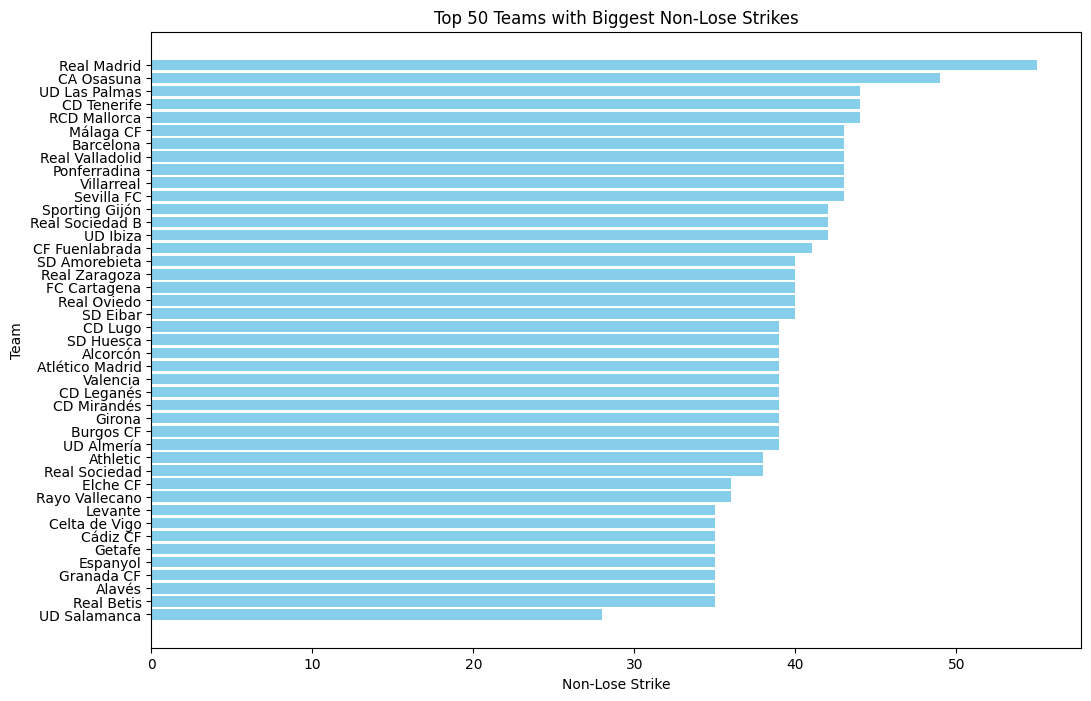

In [300]:
top_50_non_lose_strike_df = non_lose_strike_df.head(50)

plt.figure(figsize=(12, 8))
plt.barh(
    top_50_non_lose_strike_df["team"],
    top_50_non_lose_strike_df["strike"],
    color="skyblue",
)
plt.xlabel("Non-Lose Strike")
plt.ylabel("Team")
plt.title("Top 50 Teams with Biggest Non-Lose Strikes")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest values at the top
plt.show()